In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取文件, 生成DataFrame

In [7]:
import pandas as pd
import numpy as np

# use the first line of file as columns names, if no columns names in the file, use "header=None"
train = pd.read_csv("./data/train.csv", header=[0])

test = pd.read_csv("./data/test.csv", header=[0])

In [8]:
# 读取文件指定header, 指定delimiter
cols = ['user','item','rating','timestamp']

train = pd.read_csv('./data/ua.base',delimiter='\t',names = cols)
train.head()

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


# 查看一下数据结构

## 查看各个feature取值的集合的大小

In [16]:
# prepare data
train = pd.read_csv("./data/titanic/train.csv")

train.nunique()

PassengerId    712
Survived         2
Pclass           3
Name           712
Sex              2
Age             82
SibSp            7
Parch            7
Ticket         570
Fare           235
Cabin          128
Embarked         3
dtype: int64

## 分析某个feature的各个取值比例

<AxesSubplot:>

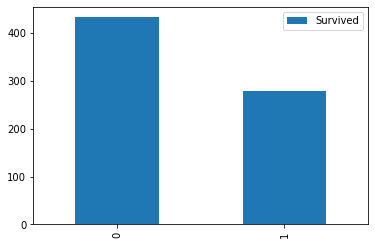

In [19]:
# series.value_counts
pd.DataFrame(train.Survived.value_counts()).plot(kind="bar")

# EDA

## 查看各个特征之间的关系

In [20]:
# 查看 性别Sex 对 存活Survived 的影响
pd.DataFrame(train.groupby("Sex")["Survived"].value_counts(normalize=True)*100) # 转化成DataFrame是为了好观察

Survived
Sex    Survived           
female 1         75.390625
       0         24.609375
male   0         81.140351
       1         18.859649

In [21]:
# 查看 性别Sex 和 存活Survived 的交叉表
pd.crosstab(train.Sex, train.Survived)

Survived,0,1
Sex,,
female,63,193
male,370,86


<AxesSubplot:xlabel='Sex'>

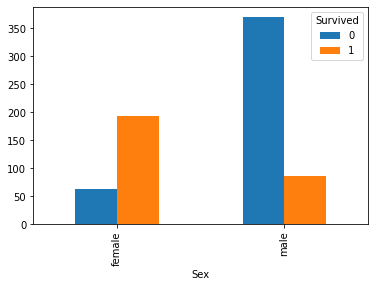

In [22]:
pd.crosstab(train.Sex, train.Survived).plot(kind="bar")
# 明显可以看出, 男性的死亡率高.

Text(0, 0.5, 'frequency')

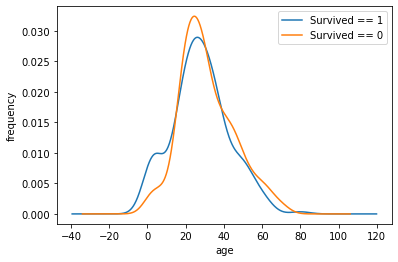

In [62]:
# 查看存活/死亡(Survived==1/0)的人群中 年龄(age)分布
ax = train.query("Survived == 1")["Age"].plot(kind="density") # 概率密度曲线
train.query("Survived == 0")["Age"].plot(kind="density")

ax.legend(labels=["Survived == 1", "Survived == 0"]) # 设置图示

ax.set_xlabel("age")
ax.set_ylabel("frequency")

# 特征工程

## 查看各个feature的空值情况

In [63]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            146
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          544
Embarked         2
dtype: int64

## 填充空缺值

### 对一列的空值填充:固定值

In [ ]:
train.Embarked.fillna("S", inplace=True)

### 对一列的空值填充:中位数

In [ ]:
# 车票跟船舱等级Pclass & 出发地Embarked 有关系
test_empty_fare = test[test.Fare.isna()]

# bool索引 & 使用中位数median进行填充
median = test[(test.Embarked=="S") & (test.Pclass==3)].Fare.median()

# 填充                                
test.Fare.fillna(median, inplace=True)

### 针对每行数据, 进行不同的空值填充

#### 数据分桶(船票价格)

In [ ]:
# 根据排序 或 基于样本分位数 将变量 分到大小相等的桶中。
# pandas.qcut(x, q, labels=None) 
train_fare_grp = pd.qcut(train.Fare, 4, labels=['Economy','Economy Plus','Business','First'])
train_fare_grp

In [ ]:
## 增加一列数据
train['Fare_Grp'] = train_fare_grp
train.head()

#### 根据"船票的等级Fare_Grp" 和 "船舱等级 Pclass" 对 "Cabin"进行填充

In [ ]:
def fill_cabin(df):
    # 遍历df的所有行
    for i in range(len(df)):
        # 找到cabin为空的行
        if (df.Cabin.isna()[i]):
            # 获取该行样本的 Pclass 和 Fare_Grp
            pclass = df.iloc[i, :]["Pclass"]
            fare_grp = df.iloc[i, :]["Fare_Grp"]
            # 取满足pclass or fare_grp相等的所有样本的cabin众数.
            cabin_mode = df[(df['Pclass'] == pclass) | (df['Fare_Grp'] == fare_grp)].Cabin.mode().values[0] # 众数可能不止一个, 取第一个
            # 填充cabin空值
            df["Cabin"].iloc[i] = cabin_mode # OK 先取列, 再取行
            # df.iloc[i]["Cabin"] = cabin_mode # not work

train.isna().sum()
fill_cabin(train)


## 对一个column的内容进行mapper替换

In [ ]:
# 替换DataFrame/Series的值
# DataFrame/Series.replace(to_replace=None, value=None, inplace=False)

# 两个list长度要相等, 一一对应替换
train.Name.replace(["Mr.", "Mrs."], ["MR.", "MRS."], inplace=True)
train.head()

## 拼接train和test数据集

In [ ]:
tmp_test = pd.DataFrame(np.random.randint(0,5,size=(2,3)), columns=["first", "second", "third"])
tmp_train = pd.DataFrame(np.random.randint(6,10,size=(3,3)), columns=["first", "second", "third"])


data = pd.concat([tmp_test, tmp_train], axis=0, ignore_index=True)

## one-hot编码

In [ ]:
data["label"] = ["A", "B", "A", "B", "A"]
# DataFrame不会对整数进行one-hot编码, 但是Series会.
pd.get_dummies(data, drop_first=True)